# Simple Black-Litterman

## Read Packages

In [112]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import pypfopt as pyp
import random

## Step 1

In [34]:
# Set assets and observations
n_assets = 16
n_obs = 1000

# Set covariance - this is the same as Markowitz
r = np.random.uniform(0.8, 0.9, (n_assets,n_assets))
np.fill_diagonal(r, 1)

# Generate Sample - this is the same as Markowitz
sample = return_vec = np.random.multivariate_normal(np.zeros(n_assets), cov = r, size = n_obs)

# Calculate risk aversion parameter delta
w_m = np.random.randn(n_assets) # market portfolio
w_m = w_m / (w_m.sum()) # sets sum of market portfolio to 1
sigma_m = w_m.T * r * w_m
delta = w_m/sigma_m**2

<ipython-input-34-576e9b590cce>:10: RuntimeWarning: covariance is not positive-semidefinite.
  sample = return_vec = np.random.multivariate_normal(np.zeros(n_assets), cov = r, size = n_obs)


In [57]:
w_m

array([-4.2791025 ,  0.1413914 ,  2.89925624, -2.64069321,  1.96479555,
       -0.54059767,  3.55048307, -4.74191789, -2.39212122,  2.82025414,
       -1.78505366,  2.26572623, -0.05146613,  4.83964692, -0.75185528,
       -0.298746  ])

In [35]:
# This is step 1: equilibrium returns
mu_est = sample.mean(0).reshape(n_assets,1)
sigma_est = np.cov(sample.T)

w_eq = np.linalg.solve(delta * sigma_est, mu_est)
w_eq

array([[ 1.62451461e+01],
       [ 1.09527626e-04],
       [-8.15048359e-01],
       [ 2.48876739e+00],
       [-1.63457440e+00],
       [-8.74898146e-03],
       [-3.16189307e+00],
       [-2.05968538e+01],
       [-1.59969186e+00],
       [ 9.79291434e-01],
       [-6.05039912e-01],
       [ 7.61650002e-01],
       [-2.17295980e-05],
       [ 1.87711078e+01],
       [ 1.44496069e-01],
       [-2.28524871e-03]])

## Step 2
Add market information

In [56]:
r_m = w_m @ mu_est # mean excess market return
sigma_m = w_m @ sigma_est @ w_m # variance of market portfolio
sr_m = r_m / np.sqrt(sigma_m) # sharpe-ratio
d_m = r_m/sigma_m # risk aversion of market portfolio holder

# Calculate market view
#mu_m = (d_m * sigma_est @ w_m).reshape(n_assets,1)
r_m

array([-0.00190767])

## Step 3
Combine Market Equilibrium and Market Information/Investor Views

In [37]:
def black_litterman(mu1, mu2, sigma, delta):
    '''
    Calculates the Black-Literman portfolio weights, for simplicity assumes that investor views 
    are equal to equilibrium and P omega is 1
    '''
    # pre-calculate inverses
    sigma1_inv = np.linalg.inv(sigma)
    sigma2_inv = sigma1_inv
    
    #mean
    M = np.linalg.solve(sigma1_inv + 1 * sigma2_inv,
                              sigma1_inv @ mu1 + 1 * sigma2_inv @ mu2)
    V = np.linalg.inv(sigma1_inv + 1 * sigma2_inv)
    w_tilde = np.linalg.solve(delta * sigma, M)
    return w_tilde, M, V

In [38]:
weights, mu, v = black_litterman(mu_m, mu_est, sigma_est, delta)
weights

array([[ 8.10822267e+00],
       [ 5.46695897e-05],
       [-4.05256835e-01],
       [ 1.24480503e+00],
       [-8.14983016e-01],
       [-4.35007619e-03],
       [-1.57814829e+00],
       [-1.02636488e+01],
       [-7.96942921e-01],
       [ 4.92079227e-01],
       [-3.02227898e-01],
       [ 3.79827041e-01],
       [-1.08411414e-05],
       [ 9.38474869e+00],
       [ 7.20962376e-02],
       [-1.14075402e-03]])

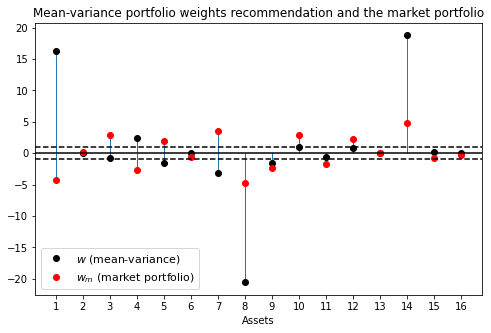

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Mean-variance portfolio weights recommendation and the market portfolio')
ax.plot(np.arange(n_assets)+1, w_eq, 'o', c='k', label='$w$ (mean-variance)')
ax.plot(np.arange(n_assets)+1, w_m, 'o', c='r', label='$w_m$ (market portfolio)')
ax.vlines(np.arange(n_assets)+1, 0, w_eq, lw=1)
ax.vlines(np.arange(n_assets)+1, 0, w_m, lw=1)
ax.axhline(0, c='k')
ax.axhline(-1, c='k', ls='--')
ax.axhline(1, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, n_assets+1, 1))
plt.legend(numpoints=1, fontsize=11)
plt.show()

rcParams['figure.figsize'] = 40, 12
fig.savefig('BlackLittermanPlot.png', dpi = 199, bbox_inches='tight')

In [46]:
n_assets = 4
n_obs = 1000
r = np.random.uniform(0.8, 0.9, (n_assets,n_assets))
np.fill_diagonal(r, 1)

In [88]:
rng = np.random.default_rng()
return_vec = rng.multivariate_normal(np.zeros(n_assets), cov = r, size = n_obs)
market_prices = pd.Series(np.random.randn(n_obs))

S = pyp.risk_models.CovarianceShrinkage(return_vec).ledoit_wolf()
delta = pyp.black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=0.5)

market_prior = pd.Series(np.ones(n_assets)*5)
view = pd.Series(np.ones(n_assets)*(1/n_assets))

<ipython-input-88-14e8b49d30ff>:2: RuntimeWarning: covariance is not positive-semidefinite.
  return_vec = rng.multivariate_normal(np.zeros(n_assets), cov = r, size = n_obs)
/Users/elizabeth/opt/anaconda3/lib/python3.8/site-packages/pypfopt/risk_models.py:389: RuntimeWarning: data is not in a dataframe
  warnings.warn("data is not in a dataframe", RuntimeWarning)


In [104]:
bl = pyp.BlackLittermanModel(S, pi=market_prior, absolute_views=view)
bl_return = bl.bl_returns()

ef = pyp.EfficientFrontier(bl_return, S)
bl.bl_weights(delta)
weights = bl.clean_weights()

S = bl.bl_cov()
type(bl_return)

pandas.core.series.Series

In [121]:
_75_perct = int(len(return_vec[:,0])*3/4)
return_vec[random.sample(list(range(1000)), _75_perct),0] = 0
return_vec

array([[ 0.        ,  0.02815974,  0.55242507,  0.53139977],
       [ 0.        ,  1.15855555,  0.95146226,  1.4496924 ],
       [-0.635711  ,  0.61910003,  0.42706851,  0.52960938],
       ...,
       [ 0.        , -1.82540306, -1.97874152, -2.06881258],
       [ 0.        ,  0.64877477,  1.09691011,  1.21232955],
       [ 0.        ,  0.50393353, -0.18678895,  0.0724312 ]])